In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
import plotly.express as px
import pandas as pd
import json
import plotly.graph_objects as go  # Ensure graph_objects is imported
import geopandas as gpd
from shapely.geometry import Point, Polygon
import pickle
from matplotlib.colors import ListedColormap

# Collecting the Data

In [13]:
# Calculating the wages for the overall Tennesse State by averaging over two years 2021 and 2022 for predicting the overall GCT value
# Source: https://www.bls.gov/oes/tables.htm

TN_Wages_2021_Median= 18.13
TN_Wages_2021_Mean= 	23.72
TN_Wages_2022_Median= 19.20
TN_Wages_2022_Mean= 25.39


TN_Wages_Median= (TN_Wages_2021_Median + TN_Wages_2022_Median)/2
TN_Wages_Mean= (TN_Wages_2021_Mean + TN_Wages_2022_Mean)/2


In [14]:
# Mileage rates (cents/mile)
# Source : https://www.irs.gov/tax-professionals/standard-mileage-rates

Business_2021= 56
Charity_2021 = 14
MedicalOrMilitary_2021= 16


Business_2022= (62.5 + 58.5)/2
Charity_2022 = (14 + 14)/2
MedicalOrMilitary_2022= (22 + 18)/2


# Calculating average for two years:
Business_mean= (Business_2021 + Business_2022)/2
Charity_mean = (Charity_2021 + Charity_2022)/2
MedicalOrMilitary_mean= (MedicalOrMilitary_2021 + MedicalOrMilitary_2022)/2

In [15]:
# Data related to the VSL
mean_VSL=12.15
mean_fatal_accident_rate_ground=1.592798223e-08
mean_fatal_accident_rate_air=5e-11

# GCT_RAM with more airports

In [16]:
df=pd.read_csv("/home/kamal/Desktop/2025-AIAA-SciTech /Dataset/Tennessee/FinalDistanceAndTimeRTN_more_airports.csv")
# Converting 'Distance' column to numeric values for comparison
df['Distance_G'] = df['Distance'].str.replace(' mi', '').astype(float)

In [17]:
# Load coefficients from the file
with open('/home/kamal/Desktop/2025-AIAA-SciTech /Dataset/Tennessee/Regression/polynomial_cost_coefficients.pkl', 'rb') as file:
    loaded_coefficients = pickle.load(file)



distances = df['Distance_H'].values  # Read the distance values from the 'distance' column

# Assuming 'loaded_coefficients' contains the polynomial coefficients for prediction
predicted_cost = np.polyval(loaded_coefficients, distances)

df=df.copy()

# Add the predicted cost column to the original DataFrame
df.loc[:, 'Cost_Airlines'] = predicted_cost * df['Distance_H']

In [18]:
# Load coefficients from the file
with open('/home/kamal/Desktop/2025-AIAA-SciTech /Dataset/Tennessee/Regression/polynomial_blockTime_coefficients.pkl', 'rb') as file:
    loaded_coefficients = pickle.load(file)



distances = df['Distance_H'].values  # Read the distance values from the 'distance' column

# Assuming 'loaded_coefficients' contains the polynomial coefficients for prediction
predicted_blockTime = np.polyval(loaded_coefficients, distances)

df=df.copy()

# Add the predicted cost column to the original DataFrame
df.loc[:, 'Time_Airlines'] = predicted_blockTime

In [19]:
# Function to convert time string to total minutes
def time_to_minutes(time_str):
    parts = time_str.split()
    hours = 0
    minutes = 0
    for i in range(0, len(parts), 2):
        if 'hour' in parts[i+1]:
            hours = int(parts[i])
        elif 'min' in parts[i+1]:
            minutes = int(parts[i])
    return hours * 60 + minutes

# Apply the function to the time column
df.loc[:,'Time_Ground'] = (df['Time'].apply(time_to_minutes))/60

In [20]:
df.loc[:,'GCT_G'] = (df['Distance_G'] * Business_mean)/100  + TN_Wages_Median * df['Time_Ground'] + df['Distance_G'] * mean_VSL * mean_fatal_accident_rate_ground  # Wages are not from MSAs, can be improved.

In [21]:
df.loc[:,'GCT_A'] = df['Cost_Airlines']  + TN_Wages_Median * df['Time_Airlines'] + df['Distance_H'] * mean_VSL * mean_fatal_accident_rate_air  # Wages are not from MSAs, can be improved.

In [22]:
# List of relevant locations
locations = ['BNA', 'MEM', 'TRI', 'TYS', 'CHA', '0A9', '0M1', 'CKV', 'CSV', 'HDI', 'M53','MOR']

# Extracting unique origin-destination pairs where either Origin or Destination is in locations but not both
unique_pairs = df[((df['Origin'].isin(locations)) & (~df['Destination'].isin(locations))) |
                  ((~df['Origin'].isin(locations)) & (df['Destination'].isin(locations)))]

# Finding the nearest airport from each unique origin not including the airports in the origin
nearest_Airport = unique_pairs.loc[unique_pairs.groupby('Origin')['Distance_G'].idxmin()]
nearest_Airport = nearest_Airport[~nearest_Airport['Origin'].isin(locations)] # Remove rows where Origin is in the list of relevant locations

# Display the resulting DataFrame
nearest_Airport=nearest_Airport[['Origin','Destination']]

# Rename columns in one line
nearest_Airport.rename(columns={'Origin': 'Origin', 'Destination': 'Nearest_Airport_Origin'}, inplace=True)

In [23]:
# List of relevant locations
locations = ['BNA', 'MEM', 'TRI', 'TYS', 'CHA', '0A9', '0M1', 'CKV', 'CSV', 'HDI', 'M53','MOR']
other_locations = ['16860', '17300', '17420', '27180', '27740', '28700', '28940', '32820', '34100', '34980', 'RTN1', 'RTN3']

# Ensure df has necessary columns
assert 'Origin' in df.columns and 'Destination' in df.columns and 'Distance' in df.columns

# Extract relevant origin-destination pairs
relevant_pairs = df[(df['Origin'].isin(locations) & df['Destination'].isin(other_locations)) |
                    (df['Destination'].isin(locations) & df['Origin'].isin(other_locations))]

# Create a DataFrame to store the shortest distances
shortest_distances = pd.DataFrame(columns=['Origin', 'Destination', 'Distance'])

# Iterate through each location to find the shortest distances to other locations
for loc in locations:
    # Extract pairs where loc is the origin and destination is in other_locations
    temp_df = relevant_pairs[(relevant_pairs['Origin'] == loc) & (relevant_pairs['Destination'].isin(other_locations))]
    shortest_distances = pd.concat([shortest_distances, temp_df])

# Reset index for clarity
shortest_distances.reset_index(drop=True, inplace=True)

# Find the shortest distance for each unique destination
nearest_MSA = shortest_distances.loc[shortest_distances.groupby('Destination')['Distance_G'].idxmin()]

# Reset index for clarity
nearest_MSA.reset_index(drop=True, inplace=True)

# Display the resulting DataFrame
nearest_MSA=nearest_MSA[['Origin','Destination']]

# Rename columns in one line
nearest_MSA.rename(columns={'Origin': 'Nearest_Airport_Destination', 'Destination': 'Destination'}, inplace=True)

In [24]:
# Merge the dataframes on the 'Origin' column
merged_df = df.merge(nearest_Airport, on='Origin', how='left')

# Replace NaN values in 'Nearest_Airport' with values from 'Origin'
merged_df['Nearest_Airport_Origin'].fillna(merged_df['Origin'], inplace=True)

/tmp/ipykernel_24572/1140310547.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  merged_df['Nearest_Airport_Origin'].fillna(merged_df['Origin'], inplace=True)


In [25]:
# Merge the result with nearest_MSA on the 'Destination' column
merged_df = merged_df.merge(nearest_MSA, on='Destination', how='left')

# Replace NaN values in 'Nearest_Airport' with values from 'Origin'
merged_df['Nearest_Airport_Destination'].fillna(merged_df['Destination'], inplace=True)

df_total=merged_df.copy()

/tmp/ipykernel_24572/1157851547.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  merged_df['Nearest_Airport_Destination'].fillna(merged_df['Destination'], inplace=True)


In [26]:
merged_df

,Origin,Destination,Distance_H,Distance,Time,Distance_G,Cost_Airlines,Time_Airlines,Time_Ground,GCT_G,GCT_A,Nearest_Airport_Origin,Nearest_Airport_Destination
0,16860,17420,40.387499,53.1 mi,1 hour 1 min,53.1,128.148189,0.427514,1.016667,49.906844,136.127740,CHA,HDI
1,16860,27180,204.203970,261 mi,3 hours 57 mins,261.0,171.626150,1.094275,3.950000,225.759301,192.050801,CHA,M53
2,16860,27740,189.655384,225 mi,3 hours 31 mins,225.0,176.735000,1.074419,3.516667,196.701127,196.789023,CHA,0A9
3,16860,28700,195.743709,223 mi,3 hours 29 mins,223.0,174.570284,1.082994,3.483333,194.913960,194.784362,CHA,TRI
4,16860,28940,93.080011,115 mi,1 hour 47 mins,115.0,189.552107,0.759036,1.783333,100.273439,203.719521,CHA,TYS
...,...,...,...,...,...,...,...,...,...,...,...,...,...
547,RTN3,MEM,113.814439,136 mi,2 hours 3 mins,136.0,194.498798,0.883126,2.050000,117.483276,210.982344,0M1,MEM
548,RTN3,MOR,270.414853,304 mi,4 hours 40 mins,304.0,155.002458,1.151163,4.666667,264.183392,176.488922,0M1,MOR
549,RTN3,TRI,325.926717,367 mi,5 hours 24 mins,367.0,151.687790,1.213533,5.400000,314.568571,174.338379,0M1,TRI
550,RTN3,TYS,235.292065,269 mi,3 hours 59 mins,269.0,162.116729,1.128098,3.983333,231.041469,183.172683,0M1,TYS


In [27]:
# List of airports
airports = ['BNA', 'MEM', 'TRI', 'TYS', 'CHA', '0A9', '0M1', 'CKV', 'CSV', 'HDI', 'M53','MOR']

# Function to find the cost
def find_cost(origin, destination, df_total):
    row = df_total[(df_total['Origin'] == origin) & (df_total['Destination'] == destination)]
    if not row.empty:
        if origin in airports and destination in airports:
            # Both origin and destination are airports, choose GCT_A
            # print("airports")
            return row['GCT_A'].values[0]
        else:
            # Otherwise, choose GCT_G
            return row['GCT_G'].values[0]
    return 0

# Define the function to calculate the total trip cost
def calculate_total_trip_cost(row, df_total):
    cost1 = find_cost(row['Origin'], row['Nearest_Airport_Origin'], df_total)
    cost2 = find_cost(row['Nearest_Airport_Origin'], row['Nearest_Airport_Destination'], df_total)
    cost3 = find_cost(row['Nearest_Airport_Destination'], row['Destination'], df_total)
    return cost2, cost1 + cost3, cost1 + cost2 + cost3

# Apply the function to the dataframe and assign the results to new columns
merged_df[['Cost_RAM_A', 'Cost_RAM_G', 'Total_Trip_Cost']] = merged_df.apply(
    lambda row: calculate_total_trip_cost(row, df_total=df), axis=1, result_type='expand'
)

# Calculate the percentage of Cost_RAM_A in the Total_Trip_Cost and assign it to a new column
merged_df['Percentage'] = (merged_df['Cost_RAM_A'] / merged_df['Total_Trip_Cost'])

In [28]:
# Create a function to determine the lowest GCT value
def find_lowest_gct_between_ground_and_RAM(row):
    min_value = min(row['GCT_G'], row['Total_Trip_Cost'])
    if row['GCT_G'] == min_value:
        return 0
    else:
        return 1

# Apply the function to each row
merged_df['RAM_Trip'] = merged_df.apply(find_lowest_gct_between_ground_and_RAM, axis=1)

In [29]:
merged_df = merged_df.drop(columns=['Distance', 'Time'])


In [30]:
merged_df

,Origin,Destination,Distance_H,Distance_G,Cost_Airlines,Time_Airlines,Time_Ground,GCT_G,GCT_A,Nearest_Airport_Origin,Nearest_Airport_Destination,Cost_RAM_A,Cost_RAM_G,Total_Trip_Cost,Percentage,RAM_Trip
0,16860,17420,40.387499,53.1,128.148189,0.427514,1.016667,49.906844,136.127740,CHA,HDI,99.424521,37.788340,137.212861,0.724601,0
1,16860,27180,204.203970,261.0,171.626150,1.094275,3.950000,225.759301,192.050801,CHA,M53,189.201244,24.946005,214.147249,0.883510,1
2,16860,27740,189.655384,225.0,176.735000,1.074419,3.516667,196.701127,196.789023,CHA,0A9,195.541119,34.779172,230.320291,0.848996,0
3,16860,28700,195.743709,223.0,174.570284,1.082994,3.483333,194.913960,194.784362,CHA,TRI,198.098821,34.544923,232.643744,0.851511,0
4,16860,28940,93.080011,115.0,189.552107,0.759036,1.783333,100.273439,203.719521,CHA,TYS,199.723451,38.699258,238.422708,0.837686,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
547,RTN3,MEM,113.814439,136.0,194.498798,0.883126,2.050000,117.483276,210.982344,0M1,MEM,210.667410,19.815004,230.482414,0.914028,0
548,RTN3,MOR,270.414853,304.0,155.002458,1.151163,4.666667,264.183392,176.488922,0M1,MOR,176.737894,19.815004,196.552898,0.899187,1
549,RTN3,TRI,325.926717,367.0,151.687790,1.213533,5.400000,314.568571,174.338379,0M1,TRI,174.280942,19.815004,194.095946,0.897911,1
550,RTN3,TYS,235.292065,269.0,162.116729,1.128098,3.983333,231.041469,183.172683,0M1,TYS,183.931855,19.815004,203.746859,0.902747,1


In [31]:
# Rename columns in one line
merged_df.rename(columns={'Distance_H': 'Distance_A', 'Cost_Airlines': 'Cost_A' , 'Time_Airlines': 'Time_A' , 'Time_Ground': 'Time_G' , 'Cost_RAM_A': 'GCT_RAM_A' , 'Cost_RAM_G': 'GCT_RAM_G' , 'Total_Trip_Cost': 'GCT_RAM_Total' , 'Percentage': 'Percentage(GCT_RAM_A:GCT_RAM_Total)'}, inplace=True)
merged_df

,Origin,Destination,Distance_A,Distance_G,Cost_A,Time_A,Time_G,GCT_G,GCT_A,Nearest_Airport_Origin,Nearest_Airport_Destination,GCT_RAM_A,GCT_RAM_G,GCT_RAM_Total,Percentage(GCT_RAM_A:GCT_RAM_Total),RAM_Trip
0,16860,17420,40.387499,53.1,128.148189,0.427514,1.016667,49.906844,136.127740,CHA,HDI,99.424521,37.788340,137.212861,0.724601,0
1,16860,27180,204.203970,261.0,171.626150,1.094275,3.950000,225.759301,192.050801,CHA,M53,189.201244,24.946005,214.147249,0.883510,1
2,16860,27740,189.655384,225.0,176.735000,1.074419,3.516667,196.701127,196.789023,CHA,0A9,195.541119,34.779172,230.320291,0.848996,0
3,16860,28700,195.743709,223.0,174.570284,1.082994,3.483333,194.913960,194.784362,CHA,TRI,198.098821,34.544923,232.643744,0.851511,0
4,16860,28940,93.080011,115.0,189.552107,0.759036,1.783333,100.273439,203.719521,CHA,TYS,199.723451,38.699258,238.422708,0.837686,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
547,RTN3,MEM,113.814439,136.0,194.498798,0.883126,2.050000,117.483276,210.982344,0M1,MEM,210.667410,19.815004,230.482414,0.914028,0
548,RTN3,MOR,270.414853,304.0,155.002458,1.151163,4.666667,264.183392,176.488922,0M1,MOR,176.737894,19.815004,196.552898,0.899187,1
549,RTN3,TRI,325.926717,367.0,151.687790,1.213533,5.400000,314.568571,174.338379,0M1,TRI,174.280942,19.815004,194.095946,0.897911,1
550,RTN3,TYS,235.292065,269.0,162.116729,1.128098,3.983333,231.041469,183.172683,0M1,TYS,183.931855,19.815004,203.746859,0.902747,1


In [32]:
df_RAM=merged_df.copy()

In [33]:
# Values to delete
values_to_delete = ['BNA', 'MEM', 'TRI', 'TYS', 'CHA', '0A9', '0M1', 'CKV', 'CSV', 'HDI', 'M53', 'MOR']

# Keeping rows where 'Origin' or 'Destination' is in the list of values_to_delete
df_RAM_filtered_ground = df_RAM[df_RAM['Origin'].isin(values_to_delete) | df_RAM['Destination'].isin(values_to_delete)]

df_RAM_filtered_ground= df_RAM_filtered_ground[['Origin' , 'Destination' ,'Distance_G', 'Time_G', 'GCT_G']].copy()
print(df_RAM_filtered_ground)

df_RAM_filtered_airport = df_RAM[df_RAM['Origin'].isin(values_to_delete) & df_RAM['Destination'].isin(values_to_delete)]

df_RAM_filtered_airport= df_RAM_filtered_airport[['Origin' , 'Destination' ,'Distance_A', 'Cost_A', 'Time_A', 'GCT_A']].copy()

df_RAM_filtered_airport


    Origin Destination  Distance_G    Time_G       GCT_G
9    16860         0A9       232.0  3.600000  202.334045
10   16860         0M1       223.0  3.400000  193.358543
11   16860         BNA       126.0  2.000000  110.725024
12   16860         CHA        14.5  0.400000   15.912253
13   16860         CKV       184.0  2.900000  161.308536
..     ...         ...         ...       ...         ...
546   RTN3         M53        62.2  0.966667   54.274345
547   RTN3         MEM       136.0  2.050000  117.483276
548   RTN3         MOR       304.0  4.666667  264.183392
549   RTN3         TRI       367.0  5.400000  314.568571
550   RTN3         TYS       269.0  3.983333  231.041469

[420 rows x 5 columns]


,Origin,Destination,Distance_A,Cost_A,Time_A,GCT_A
240,0A9,0M1,336.607410,151.852674,1.240555,175.007641
241,0A9,BNA,251.564015,158.293115,1.140312,179.577031
242,0A9,CHA,193.438426,175.386818,1.079791,195.541119
243,0A9,CKV,291.613777,152.724707,1.164632,174.462564
244,0A9,CSV,164.969645,185.387158,1.035077,204.706865
...,...,...,...,...,...,...
499,TYS,HDI,62.492379,164.830496,0.518187,174.502451
500,TYS,M53,273.552305,154.573254,1.152885,176.091857
501,TYS,MEM,341.032334,151.967332,1.253645,175.366608
502,TYS,MOR,42.825873,133.161098,0.426276,141.117530


In [34]:
# Values to delete
values_to_delete = ['BNA', 'MEM', 'TRI', 'TYS', 'CHA', '0A9', '0M1', 'CKV', 'CSV', 'HDI', 'M53','MOR']

# Deleting rows where 'origin' or 'destination' is in the list of values_to_delete to find the pairs of MSAs as OD
df_RAM = df_RAM[~df_RAM['Origin'].isin(values_to_delete) & ~df_RAM['Destination'].isin(values_to_delete)]

df_RAM = df_RAM.drop(columns=['Distance_A', 'Distance_G' , 'Cost_A', 'Time_A', 'Time_G', 'GCT_G', 'GCT_A'])

df_RAM

,Origin,Destination,Nearest_Airport_Origin,Nearest_Airport_Destination,GCT_RAM_A,GCT_RAM_G,GCT_RAM_Total,Percentage(GCT_RAM_A:GCT_RAM_Total),RAM_Trip
0,16860,17420,CHA,HDI,99.424521,37.788340,137.212861,0.724601,0
1,16860,27180,CHA,M53,189.201244,24.946005,214.147249,0.883510,1
2,16860,27740,CHA,0A9,195.541119,34.779172,230.320291,0.848996,0
3,16860,28700,CHA,TRI,198.098821,34.544923,232.643744,0.851511,0
4,16860,28940,CHA,TYS,199.723451,38.699258,238.422708,0.837686,0
...,...,...,...,...,...,...,...,...,...
535,RTN3,32820,0M1,MEM,210.667410,30.443839,241.111249,0.873735,0
536,RTN3,34100,0M1,MOR,176.737894,24.284171,201.022065,0.879196,1
537,RTN3,34980,0M1,BNA,200.467139,24.051171,224.518310,0.892877,0
538,RTN3,17300,0M1,CKV,193.217234,38.018841,231.236074,0.835584,0


In [35]:
df_origin_ground = df_RAM.merge(df_RAM_filtered_ground, how='left', left_on=['Origin', 'Nearest_Airport_Origin'], right_on=['Origin', 'Destination'], suffixes=('', '_origin'))
df_origin_ground

,Origin,Destination,Nearest_Airport_Origin,Nearest_Airport_Destination,GCT_RAM_A,GCT_RAM_G,GCT_RAM_Total,Percentage(GCT_RAM_A:GCT_RAM_Total),RAM_Trip,Destination_origin,Distance_G,Time_G,GCT_G
0,16860,17420,CHA,HDI,99.424521,37.788340,137.212861,0.724601,0,CHA,14.5,0.4,15.912253
1,16860,27180,CHA,M53,189.201244,24.946005,214.147249,0.883510,1,CHA,14.5,0.4,15.912253
2,16860,27740,CHA,0A9,195.541119,34.779172,230.320291,0.848996,0,CHA,14.5,0.4,15.912253
3,16860,28700,CHA,TRI,198.098821,34.544923,232.643744,0.851511,0,CHA,14.5,0.4,15.912253
4,16860,28940,CHA,TYS,199.723451,38.699258,238.422708,0.837686,0,CHA,14.5,0.4,15.912253
...,...,...,...,...,...,...,...,...,...,...,...,...,...
127,RTN3,32820,0M1,MEM,210.667410,30.443839,241.111249,0.873735,0,0M1,21.2,0.4,19.815004
128,RTN3,34100,0M1,MOR,176.737894,24.284171,201.022065,0.879196,1,0M1,21.2,0.4,19.815004
129,RTN3,34980,0M1,BNA,200.467139,24.051171,224.518310,0.892877,0,0M1,21.2,0.4,19.815004
130,RTN3,17300,0M1,CKV,193.217234,38.018841,231.236074,0.835584,0,0M1,21.2,0.4,19.815004


In [36]:
df_air_trip = df_origin_ground.merge(df_RAM_filtered_airport, how='left', left_on=['Nearest_Airport_Origin', 'Nearest_Airport_Destination'], right_on=['Origin', 'Destination'], suffixes=('', '_air'))
df_air_trip

,Origin,Destination,Nearest_Airport_Origin,Nearest_Airport_Destination,GCT_RAM_A,GCT_RAM_G,GCT_RAM_Total,Percentage(GCT_RAM_A:GCT_RAM_Total),RAM_Trip,Destination_origin,Distance_G,Time_G,GCT_G,Origin_air,Destination_air,Distance_A,Cost_A,Time_A,GCT_A
0,16860,17420,CHA,HDI,99.424521,37.788340,137.212861,0.724601,0,CHA,14.5,0.4,15.912253,CHA,HDI,24.565487,88.804116,0.569001,99.424521
1,16860,27180,CHA,M53,189.201244,24.946005,214.147249,0.883510,1,CHA,14.5,0.4,15.912253,CHA,M53,213.392772,168.564816,1.105622,189.201244
2,16860,27740,CHA,0A9,195.541119,34.779172,230.320291,0.848996,0,CHA,14.5,0.4,15.912253,CHA,0A9,193.438426,175.386818,1.079791,195.541119
3,16860,28700,CHA,TRI,198.098821,34.544923,232.643744,0.851511,0,CHA,14.5,0.4,15.912253,CHA,TRI,185.693477,178.152775,1.068634,198.098821
4,16860,28940,CHA,TYS,199.723451,38.699258,238.422708,0.837686,0,CHA,14.5,0.4,15.912253,CHA,TYS,86.792127,186.422281,0.712626,199.723451
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
127,RTN3,32820,0M1,MEM,210.667410,30.443839,241.111249,0.873735,0,0M1,21.2,0.4,19.815004,0M1,MEM,112.024892,194.349789,0.874236,210.667410
128,RTN3,34100,0M1,MOR,176.737894,24.284171,201.022065,0.879196,1,0M1,21.2,0.4,19.815004,0M1,MOR,268.571702,155.270136,1.150161,176.737894
129,RTN3,34980,0M1,BNA,200.467139,24.051171,224.518310,0.892877,0,0M1,21.2,0.4,19.815004,0M1,BNA,87.857804,187.014554,0.720739,200.467139
130,RTN3,17300,0M1,CKV,193.217234,38.018841,231.236074,0.835584,0,0M1,21.2,0.4,19.815004,0M1,CKV,78.786572,181.100470,0.649170,193.217234


In [37]:
df_final = df_air_trip.merge(df_RAM_filtered_ground, how='left', left_on=['Nearest_Airport_Destination', 'Destination'], right_on=['Origin', 'Destination'], suffixes=('', '_destination'))
df_final

,Origin,Destination,Nearest_Airport_Origin,Nearest_Airport_Destination,GCT_RAM_A,GCT_RAM_G,GCT_RAM_Total,Percentage(GCT_RAM_A:GCT_RAM_Total),RAM_Trip,Destination_origin,...,Origin_air,Destination_air,Distance_A,Cost_A,Time_A,GCT_A,Origin_destination,Distance_G_destination,Time_G_destination,GCT_G_destination
0,16860,17420,CHA,HDI,99.424521,37.788340,137.212861,0.724601,0,CHA,...,CHA,HDI,24.565487,88.804116,0.569001,99.424521,HDI,21.0,0.516667,21.876087
1,16860,27180,CHA,M53,189.201244,24.946005,214.147249,0.883510,1,CHA,...,CHA,M53,213.392772,168.564816,1.105622,189.201244,M53,9.1,0.200000,9.033752
2,16860,27740,CHA,0A9,195.541119,34.779172,230.320291,0.848996,0,CHA,...,CHA,0A9,193.438426,175.386818,1.079791,195.541119,0A9,15.3,0.533333,18.866920
3,16860,28700,CHA,TRI,198.098821,34.544923,232.643744,0.851511,0,CHA,...,CHA,TRI,185.693477,178.152775,1.068634,198.098821,TRI,16.5,0.483333,18.632670
4,16860,28940,CHA,TYS,199.723451,38.699258,238.422708,0.837686,0,CHA,...,CHA,TYS,86.792127,186.422281,0.712626,199.723451,TYS,24.7,0.450000,22.787005
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
127,RTN3,32820,0M1,MEM,210.667410,30.443839,241.111249,0.873735,0,0M1,...,0M1,MEM,112.024892,194.349789,0.874236,210.667410,MEM,8.1,0.316667,10.628835
128,RTN3,34100,0M1,MOR,176.737894,24.284171,201.022065,0.879196,1,0M1,...,0M1,MOR,268.571702,155.270136,1.150161,176.737894,MOR,3.4,0.133333,4.469167
129,RTN3,34980,0M1,BNA,200.467139,24.051171,224.518310,0.892877,0,0M1,...,0M1,BNA,87.857804,187.014554,0.720739,200.467139,BNA,3.0,0.133333,4.236167
130,RTN3,17300,0M1,CKV,193.217234,38.018841,231.236074,0.835584,0,0M1,...,0M1,CKV,78.786572,181.100470,0.649170,193.217234,CKV,17.9,0.416667,18.203837


In [38]:
df_final = df_final.drop(columns=['Origin_destination', 'Destination_origin', 'Origin_air', 'Destination_air', 'Nearest_Airport_Origin', 'Nearest_Airport_Destination', 'GCT_RAM_A'])
df_final.rename(columns={'GCT_RAM_G': 'GCT_Total_G', 'GCT_RAM_Total': 'GCT_Total' , 'Distance_G': 'Distance_G_origin' , 'Time_G': 'Time_G_origin', 'GCT_G': 'GCT_G_origin'}, inplace=True)
df_final

,Origin,Destination,GCT_Total_G,GCT_Total,Percentage(GCT_RAM_A:GCT_RAM_Total),RAM_Trip,Distance_G_origin,Time_G_origin,GCT_G_origin,Distance_A,Cost_A,Time_A,GCT_A,Distance_G_destination,Time_G_destination,GCT_G_destination
0,16860,17420,37.788340,137.212861,0.724601,0,14.5,0.4,15.912253,24.565487,88.804116,0.569001,99.424521,21.0,0.516667,21.876087
1,16860,27180,24.946005,214.147249,0.883510,1,14.5,0.4,15.912253,213.392772,168.564816,1.105622,189.201244,9.1,0.200000,9.033752
2,16860,27740,34.779172,230.320291,0.848996,0,14.5,0.4,15.912253,193.438426,175.386818,1.079791,195.541119,15.3,0.533333,18.866920
3,16860,28700,34.544923,232.643744,0.851511,0,14.5,0.4,15.912253,185.693477,178.152775,1.068634,198.098821,16.5,0.483333,18.632670
4,16860,28940,38.699258,238.422708,0.837686,0,14.5,0.4,15.912253,86.792127,186.422281,0.712626,199.723451,24.7,0.450000,22.787005
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
127,RTN3,32820,30.443839,241.111249,0.873735,0,21.2,0.4,19.815004,112.024892,194.349789,0.874236,210.667410,8.1,0.316667,10.628835
128,RTN3,34100,24.284171,201.022065,0.879196,1,21.2,0.4,19.815004,268.571702,155.270136,1.150161,176.737894,3.4,0.133333,4.469167
129,RTN3,34980,24.051171,224.518310,0.892877,0,21.2,0.4,19.815004,87.857804,187.014554,0.720739,200.467139,3.0,0.133333,4.236167
130,RTN3,17300,38.018841,231.236074,0.835584,0,21.2,0.4,19.815004,78.786572,181.100470,0.649170,193.217234,17.9,0.416667,18.203837


# Visualization

In [39]:
df=df_final.copy()
df

,Origin,Destination,GCT_Total_G,GCT_Total,Percentage(GCT_RAM_A:GCT_RAM_Total),RAM_Trip,Distance_G_origin,Time_G_origin,GCT_G_origin,Distance_A,Cost_A,Time_A,GCT_A,Distance_G_destination,Time_G_destination,GCT_G_destination
0,16860,17420,37.788340,137.212861,0.724601,0,14.5,0.4,15.912253,24.565487,88.804116,0.569001,99.424521,21.0,0.516667,21.876087
1,16860,27180,24.946005,214.147249,0.883510,1,14.5,0.4,15.912253,213.392772,168.564816,1.105622,189.201244,9.1,0.200000,9.033752
2,16860,27740,34.779172,230.320291,0.848996,0,14.5,0.4,15.912253,193.438426,175.386818,1.079791,195.541119,15.3,0.533333,18.866920
3,16860,28700,34.544923,232.643744,0.851511,0,14.5,0.4,15.912253,185.693477,178.152775,1.068634,198.098821,16.5,0.483333,18.632670
4,16860,28940,38.699258,238.422708,0.837686,0,14.5,0.4,15.912253,86.792127,186.422281,0.712626,199.723451,24.7,0.450000,22.787005
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
127,RTN3,32820,30.443839,241.111249,0.873735,0,21.2,0.4,19.815004,112.024892,194.349789,0.874236,210.667410,8.1,0.316667,10.628835
128,RTN3,34100,24.284171,201.022065,0.879196,1,21.2,0.4,19.815004,268.571702,155.270136,1.150161,176.737894,3.4,0.133333,4.469167
129,RTN3,34980,24.051171,224.518310,0.892877,0,21.2,0.4,19.815004,87.857804,187.014554,0.720739,200.467139,3.0,0.133333,4.236167
130,RTN3,17300,38.018841,231.236074,0.835584,0,21.2,0.4,19.815004,78.786572,181.100470,0.649170,193.217234,17.9,0.416667,18.203837


In [40]:
df['Distance_G'] = df['Distance_G_origin'] + df['Distance_G_destination']

df['Time_G'] = df['Time_G_origin'] + df['Time_G_destination']

# Dropping the original columns
df = df.drop(columns=['Distance_G_origin', 'Distance_G_destination', 'Time_G_destination', 'Time_G_origin', 'GCT_G_origin', 'GCT_G_destination'])

df

,Origin,Destination,GCT_Total_G,GCT_Total,Percentage(GCT_RAM_A:GCT_RAM_Total),RAM_Trip,Distance_A,Cost_A,Time_A,GCT_A,Distance_G,Time_G
0,16860,17420,37.788340,137.212861,0.724601,0,24.565487,88.804116,0.569001,99.424521,35.5,0.916667
1,16860,27180,24.946005,214.147249,0.883510,1,213.392772,168.564816,1.105622,189.201244,23.6,0.600000
2,16860,27740,34.779172,230.320291,0.848996,0,193.438426,175.386818,1.079791,195.541119,29.8,0.933333
3,16860,28700,34.544923,232.643744,0.851511,0,185.693477,178.152775,1.068634,198.098821,31.0,0.883333
4,16860,28940,38.699258,238.422708,0.837686,0,86.792127,186.422281,0.712626,199.723451,39.2,0.850000
...,...,...,...,...,...,...,...,...,...,...,...,...
127,RTN3,32820,30.443839,241.111249,0.873735,0,112.024892,194.349789,0.874236,210.667410,29.3,0.716667
128,RTN3,34100,24.284171,201.022065,0.879196,1,268.571702,155.270136,1.150161,176.737894,24.6,0.533333
129,RTN3,34980,24.051171,224.518310,0.892877,0,87.857804,187.014554,0.720739,200.467139,24.2,0.533333
130,RTN3,17300,38.018841,231.236074,0.835584,0,78.786572,181.100470,0.649170,193.217234,39.1,0.816667


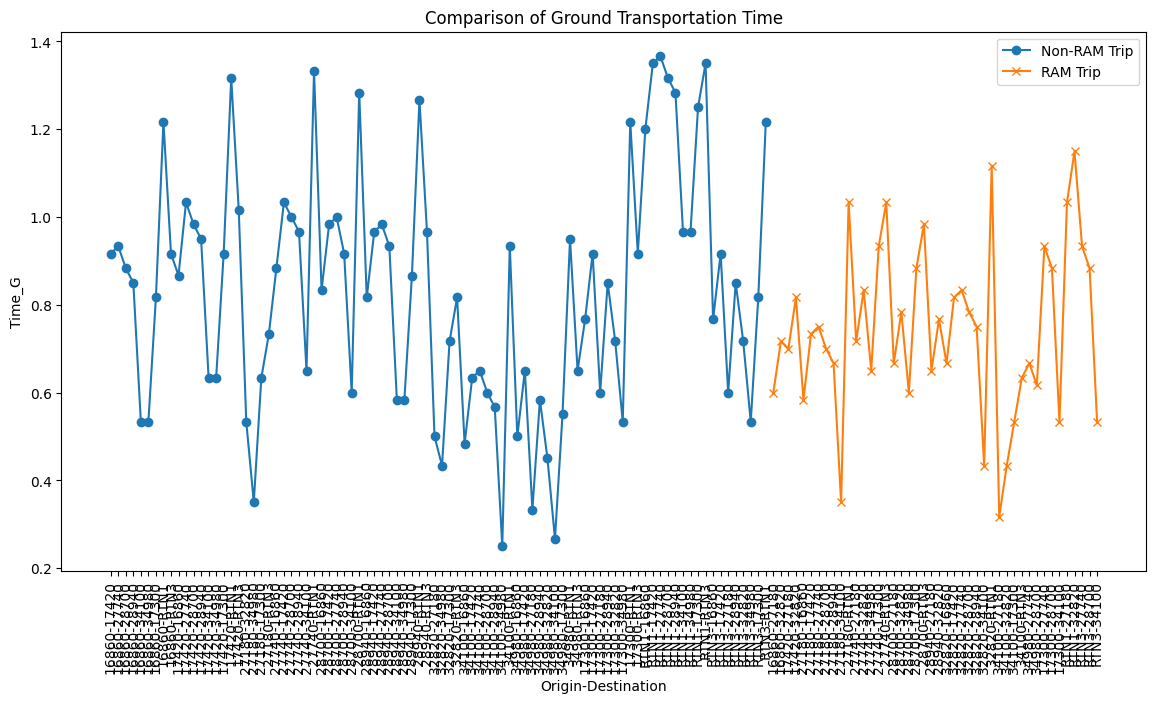

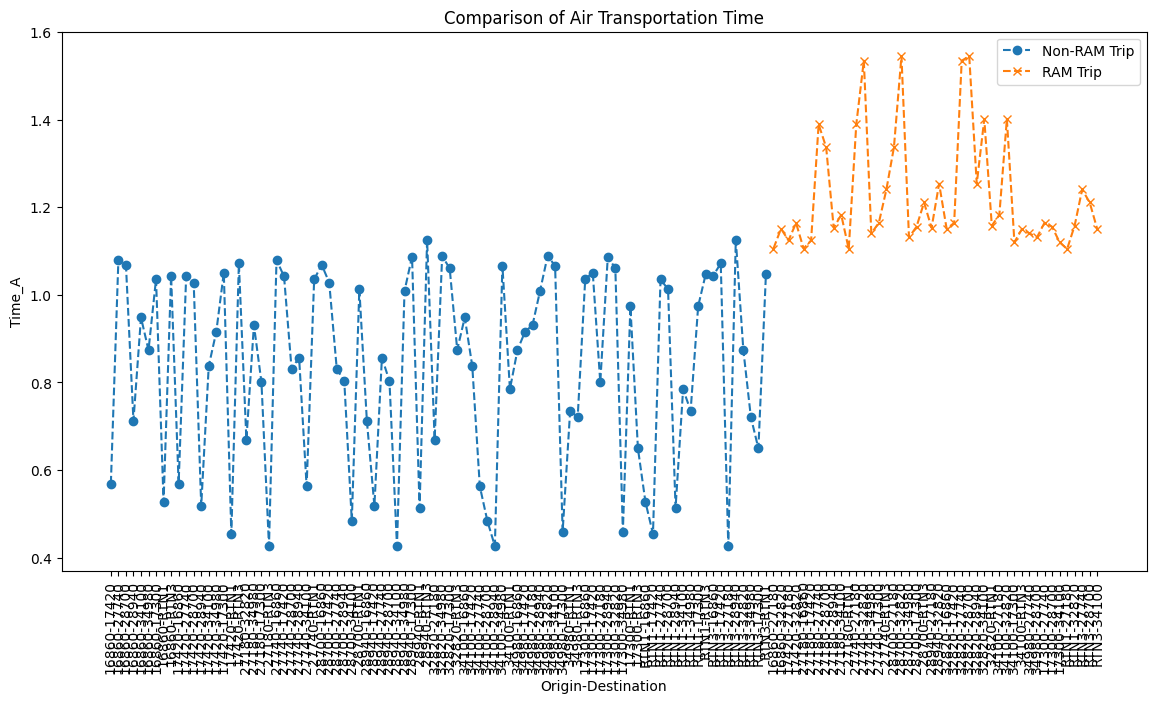

In [41]:
# Filter the data based on RAM_Trip
df_RAM_Trip_0 = df[df['RAM_Trip'] == 0]
df_RAM_Trip_1 = df[df['RAM_Trip'] == 1]

# Plotting the line graph
plt.figure(figsize=(14, 7))

# Plot for RAM_Trip == 0
plt.plot(df_RAM_Trip_0['Origin'].astype(str) + '-' + df_RAM_Trip_0['Destination'].astype(str), df_RAM_Trip_0['Time_G'], label='Non-RAM Trip', marker='o')

# Plot for RAM_Trip == 1
plt.plot(df_RAM_Trip_1['Origin'].astype(str) + '-' + df_RAM_Trip_1['Destination'].astype(str), df_RAM_Trip_1['Time_G'], label='RAM Trip', marker='x')

# Adding titles and labels
plt.title('Comparison of Ground Transportation Time')
plt.xlabel('Origin-Destination')
plt.ylabel('Time_G')
plt.xticks(rotation=90)
plt.legend()

# Display the plot
plt.show()

# Plotting the line graph for Time_A
plt.figure(figsize=(14, 7))

# Plot for RAM_Trip == 0
plt.plot(df_RAM_Trip_0['Origin'].astype(str) + '-' + df_RAM_Trip_0['Destination'].astype(str), df_RAM_Trip_0['Time_A'], label='Non-RAM Trip', marker='o', linestyle='--')

# Plot for RAM_Trip == 1
plt.plot(df_RAM_Trip_1['Origin'].astype(str) + '-' + df_RAM_Trip_1['Destination'].astype(str), df_RAM_Trip_1['Time_A'], label='RAM Trip', marker='x', linestyle='--')

# Adding titles and labels
plt.title('Comparison of Air Transportation Time')
plt.xlabel('Origin-Destination')
plt.ylabel('Time_A')
plt.xticks(rotation=90)
plt.legend()

# Display the plot
plt.show()

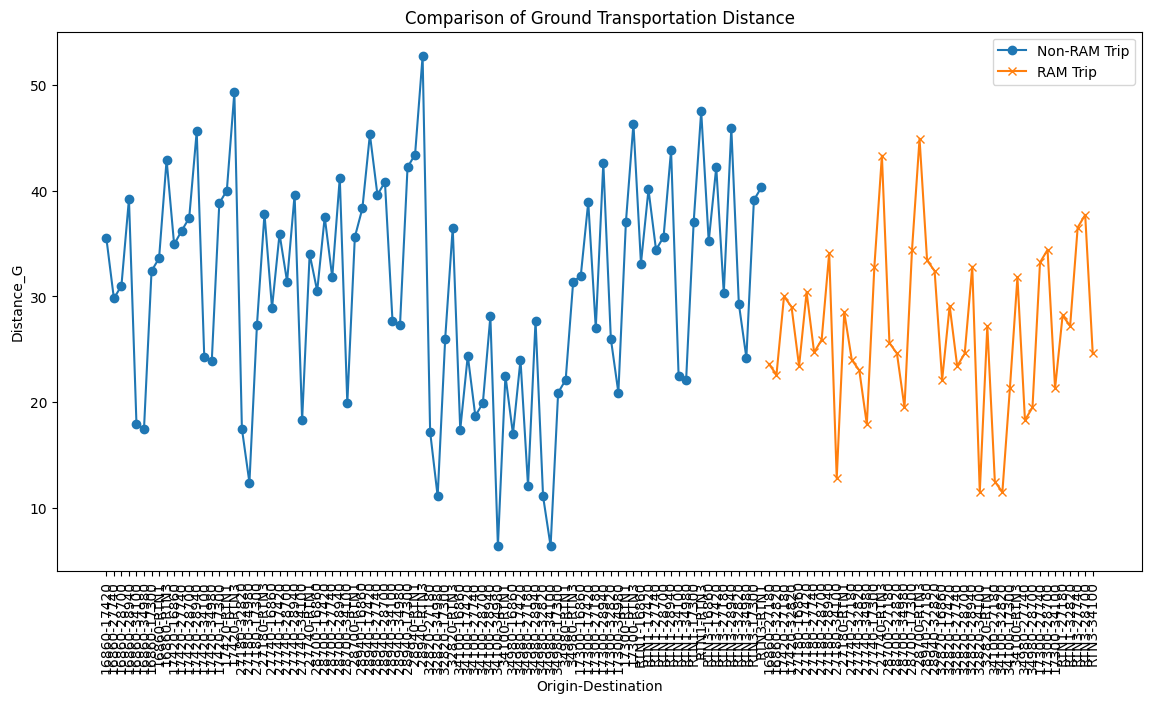

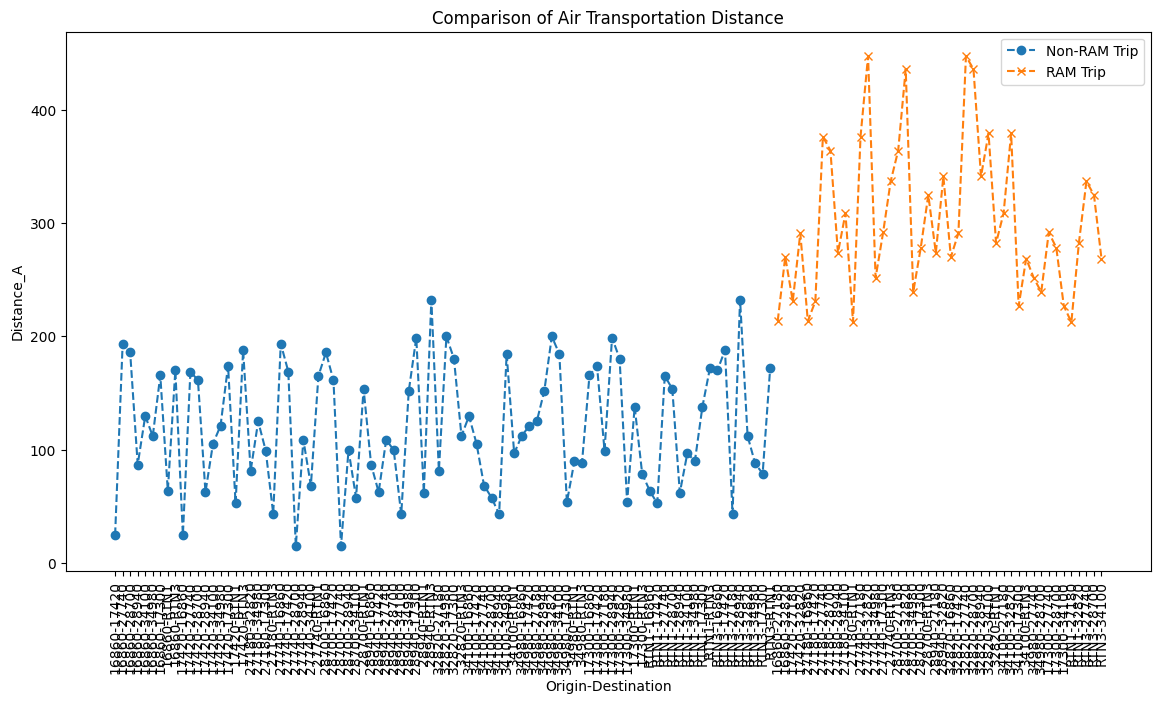

In [42]:
# Filter the data based on RAM_Trip
df_RAM_Trip_0 = df[df['RAM_Trip'] == 0]
df_RAM_Trip_1 = df[df['RAM_Trip'] == 1]

# Plotting the line graph
plt.figure(figsize=(14, 7))

# Plot for RAM_Trip == 0
plt.plot(df_RAM_Trip_0['Origin'].astype(str) + '-' + df_RAM_Trip_0['Destination'].astype(str), df_RAM_Trip_0['Distance_G'], label='Non-RAM Trip', marker='o')

# Plot for RAM_Trip == 1
plt.plot(df_RAM_Trip_1['Origin'].astype(str) + '-' + df_RAM_Trip_1['Destination'].astype(str), df_RAM_Trip_1['Distance_G'], label='RAM Trip', marker='x')

# Adding titles and labels
plt.title('Comparison of Ground Transportation Distance')
plt.xlabel('Origin-Destination')
plt.ylabel('Distance_G')
plt.xticks(rotation=90)
plt.legend()

# Display the plot
plt.show()

# Plotting the line graph for Time_A
plt.figure(figsize=(14, 7))

# Plot for RAM_Trip == 0
plt.plot(df_RAM_Trip_0['Origin'].astype(str) + '-' + df_RAM_Trip_0['Destination'].astype(str), df_RAM_Trip_0['Distance_A'], label='Non-RAM Trip', marker='o', linestyle='--')

# Plot for RAM_Trip == 1
plt.plot(df_RAM_Trip_1['Origin'].astype(str) + '-' + df_RAM_Trip_1['Destination'].astype(str), df_RAM_Trip_1['Distance_A'], label='RAM Trip', marker='x', linestyle='--')

# Adding titles and labels
plt.title('Comparison of Air Transportation Distance')
plt.xlabel('Origin-Destination')
plt.ylabel('Distance_A')
plt.xticks(rotation=90)
plt.legend()

# Display the plot
plt.show()

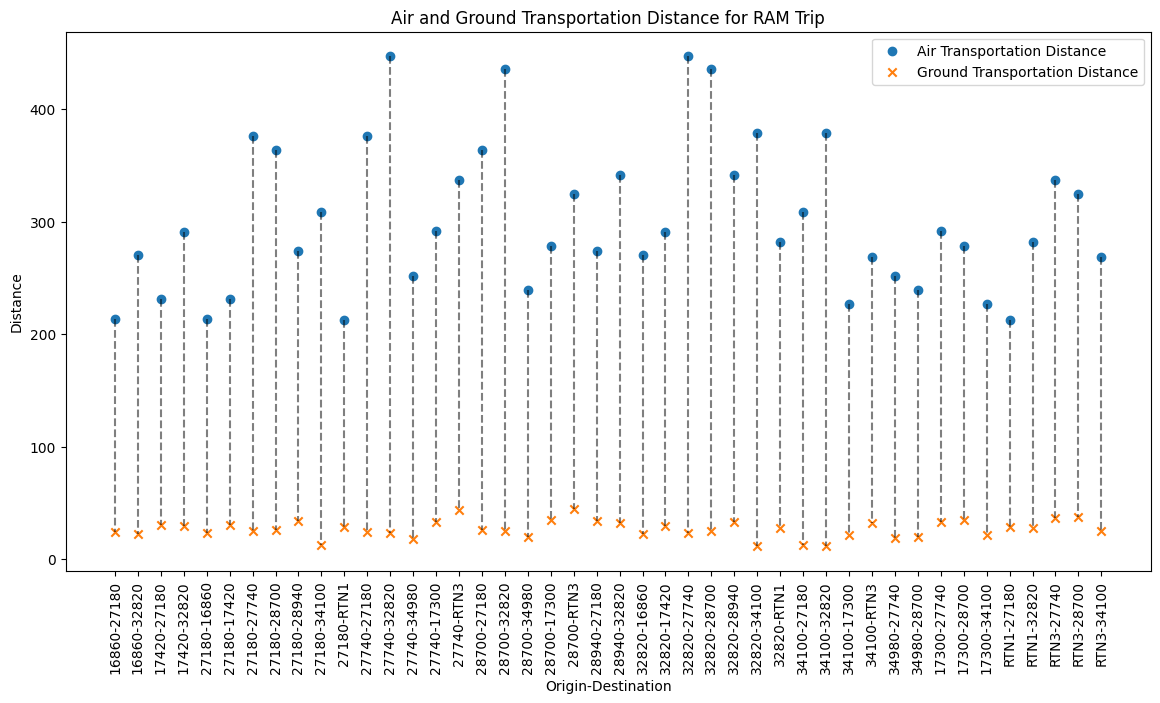

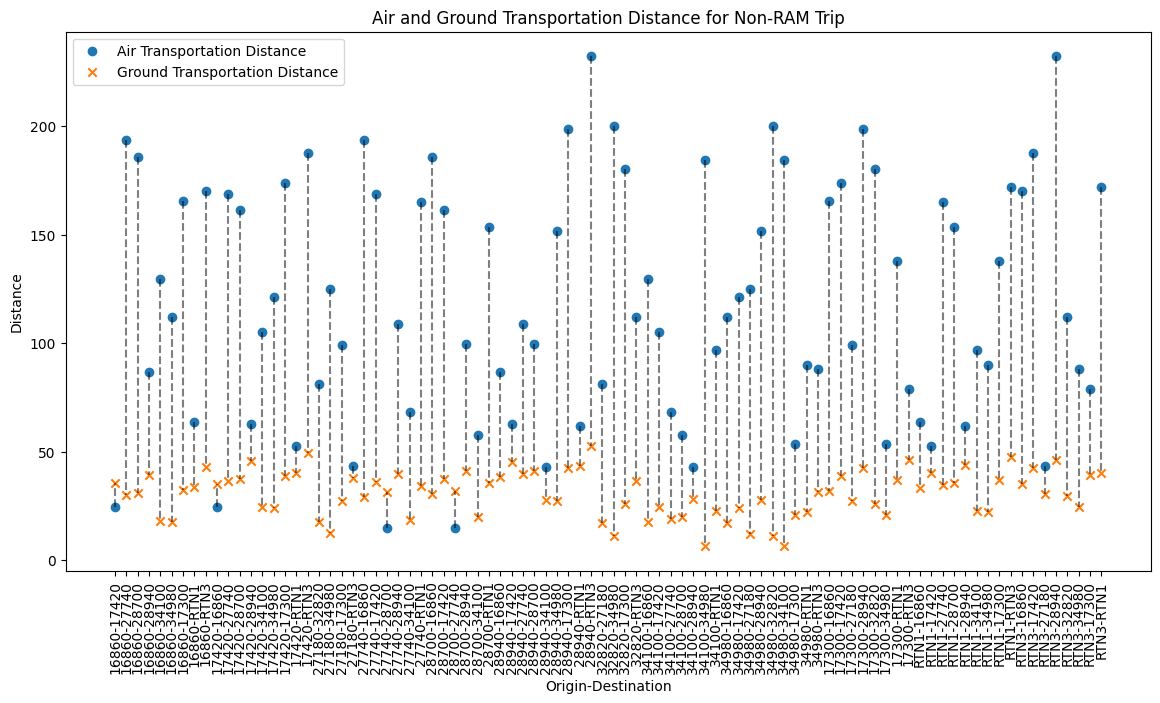

In [43]:
# Filter the data based on RAM_Trip
df_RAM_Trip_1 = df[df['RAM_Trip'] == 1].copy()

# Creating a combined Origin-Destination column for better labels
df_RAM_Trip_1['Origin-Destination'] = df_RAM_Trip_1['Origin'].astype(str) + '-' + df_RAM_Trip_1['Destination'].astype(str)

# Plotting the scatter plot for Distance_A and Distance_G in the same figure
plt.figure(figsize=(14, 7))

# Scatter plot for Distance_A
plt.scatter(df_RAM_Trip_1['Origin-Destination'], df_RAM_Trip_1['Distance_A'], label='Air Transportation Distance', marker='o')

# Scatter plot for Distance_G
plt.scatter(df_RAM_Trip_1['Origin-Destination'], df_RAM_Trip_1['Distance_G'], label='Ground Transportation Distance', marker='x')

for i in range(len(df_RAM_Trip_1)):
    plt.plot([df_RAM_Trip_1['Origin-Destination'].iloc[i], df_RAM_Trip_1['Origin-Destination'].iloc[i]],
             [df_RAM_Trip_1['Distance_A'].iloc[i], df_RAM_Trip_1['Distance_G'].iloc[i]], 'k--', alpha=0.5)

# Adding titles and labels
plt.title('Air and Ground Transportation Distance for RAM Trip')
plt.xlabel('Origin-Destination')
plt.ylabel('Distance')
plt.xticks(rotation=90)
plt.legend()

# Display the plot
plt.show()



# Filter the data based on RAM_Trip
df_RAM_Trip_0 = df[df['RAM_Trip'] == 0].copy()

# Creating a combined Origin-Destination column for better labels
df_RAM_Trip_0['Origin-Destination'] = df_RAM_Trip_0['Origin'].astype(str) + '-' + df_RAM_Trip_0['Destination'].astype(str)

# Plotting the scatter plot for Distance_A and Distance_G in the same figure
plt.figure(figsize=(14, 7))

# Scatter plot for Distance_A
plt.scatter(df_RAM_Trip_0['Origin-Destination'], df_RAM_Trip_0['Distance_A'], label='Air Transportation Distance', marker='o')

# Scatter plot for Distance_G
plt.scatter(df_RAM_Trip_0['Origin-Destination'], df_RAM_Trip_0['Distance_G'], label='Ground Transportation Distance', marker='x')

for i in range(len(df_RAM_Trip_0)):
    plt.plot([df_RAM_Trip_0['Origin-Destination'].iloc[i], df_RAM_Trip_0['Origin-Destination'].iloc[i]],
             [df_RAM_Trip_0['Distance_A'].iloc[i], df_RAM_Trip_0['Distance_G'].iloc[i]], 'k--', alpha=0.5)

# Adding titles and labels
plt.title('Air and Ground Transportation Distance for Non-RAM Trip')
plt.xlabel('Origin-Destination')
plt.ylabel('Distance')
plt.xticks(rotation=90)
plt.legend()

# Display the plot
plt.show()

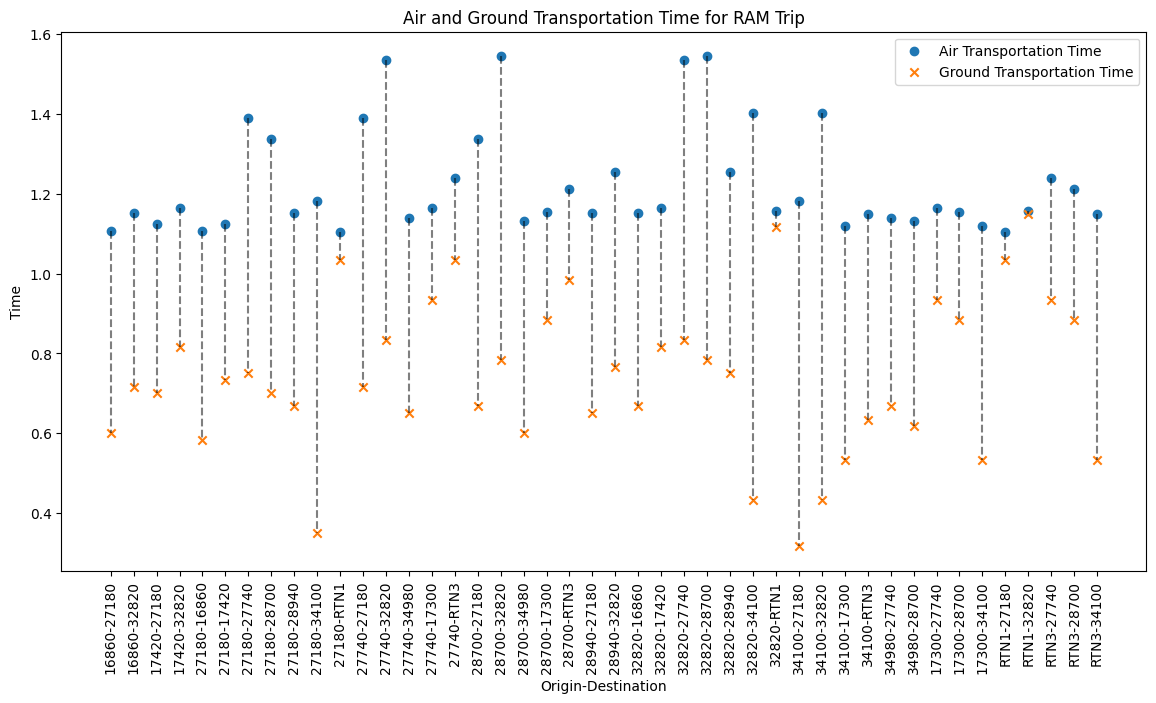

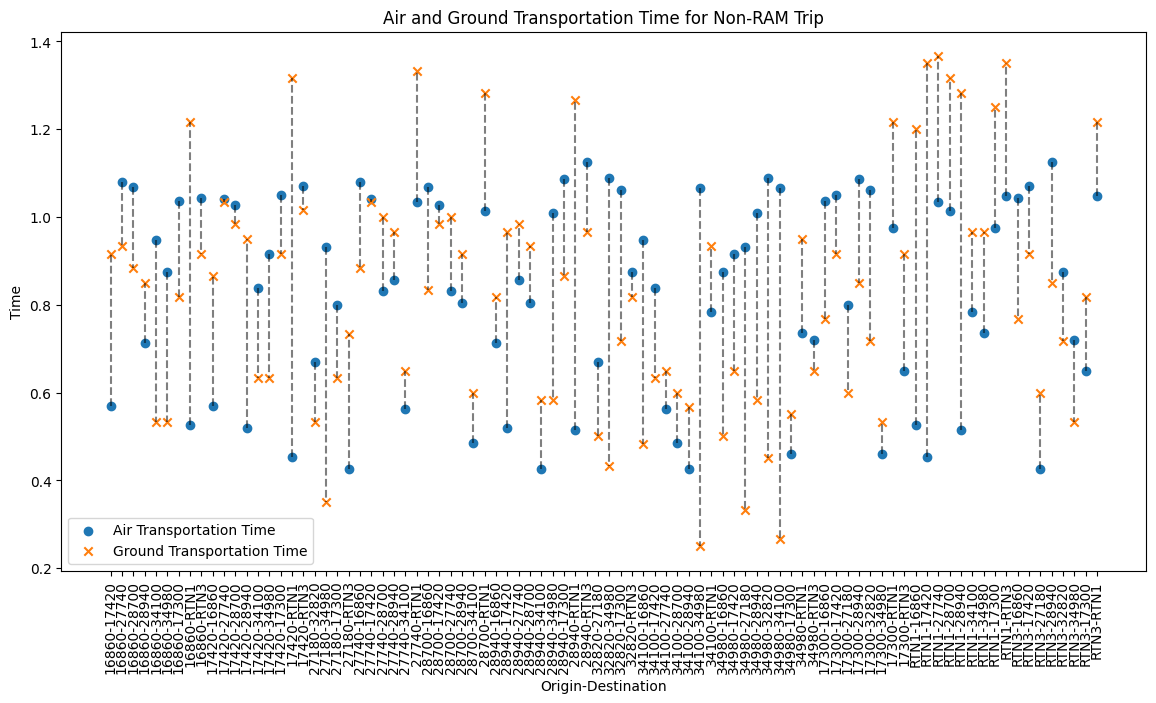

In [44]:
# Filter the data based on RAM_Trip
df_RAM_Trip_1 = df[df['RAM_Trip'] == 1].copy()

# Creating a combined Origin-Destination column for better labels
df_RAM_Trip_1['Origin-Destination'] = df_RAM_Trip_1['Origin'].astype(str) + '-' + df_RAM_Trip_1['Destination'].astype(str)

# Plotting the scatter plot for Distance_A and Distance_G in the same figure
plt.figure(figsize=(14, 7))

# Scatter plot for Distance_A
plt.scatter(df_RAM_Trip_1['Origin-Destination'], df_RAM_Trip_1['Time_A'], label='Air Transportation Time', marker='o')

# Scatter plot for Distance_G
plt.scatter(df_RAM_Trip_1['Origin-Destination'], df_RAM_Trip_1['Time_G'], label='Ground Transportation Time', marker='x')

# Drawing dotted lines between Time_A and Time_G of the same OD pair
for i in range(len(df_RAM_Trip_1)):
    plt.plot([df_RAM_Trip_1['Origin-Destination'].iloc[i], df_RAM_Trip_1['Origin-Destination'].iloc[i]],
             [df_RAM_Trip_1['Time_A'].iloc[i], df_RAM_Trip_1['Time_G'].iloc[i]], 'k--', alpha=0.5)

# Adding titles and labels
plt.title('Air and Ground Transportation Time for RAM Trip')
plt.xlabel('Origin-Destination')
plt.ylabel('Time')
plt.xticks(rotation=90)
plt.legend()

# Display the plot
plt.show()


# Filter the data based on RAM_Trip
df_RAM_Trip_0 = df[df['RAM_Trip'] == 0].copy()

# Creating a combined Origin-Destination column for better labels
df_RAM_Trip_0['Origin-Destination'] = df_RAM_Trip_0['Origin'].astype(str) + '-' + df_RAM_Trip_0['Destination'].astype(str)

# Plotting the scatter plot for Distance_A and Distance_G in the same figure
plt.figure(figsize=(14, 7))

# Scatter plot for Distance_A
plt.scatter(df_RAM_Trip_0['Origin-Destination'], df_RAM_Trip_0['Time_A'], label='Air Transportation Time', marker='o')

# Scatter plot for Distance_G
plt.scatter(df_RAM_Trip_0['Origin-Destination'], df_RAM_Trip_0['Time_G'], label='Ground Transportation Time', marker='x')

# Drawing dotted lines between Time_A and Time_G of the same OD pair
for i in range(len(df_RAM_Trip_0)):
    plt.plot([df_RAM_Trip_0['Origin-Destination'].iloc[i], df_RAM_Trip_0['Origin-Destination'].iloc[i]],
             [df_RAM_Trip_0['Time_A'].iloc[i], df_RAM_Trip_0['Time_G'].iloc[i]], 'k--', alpha=0.5)

# Adding titles and labels
plt.title('Air and Ground Transportation Time for Non-RAM Trip')
plt.xlabel('Origin-Destination')
plt.ylabel('Time')
plt.xticks(rotation=90)
plt.legend()

# Display the plot
plt.show()

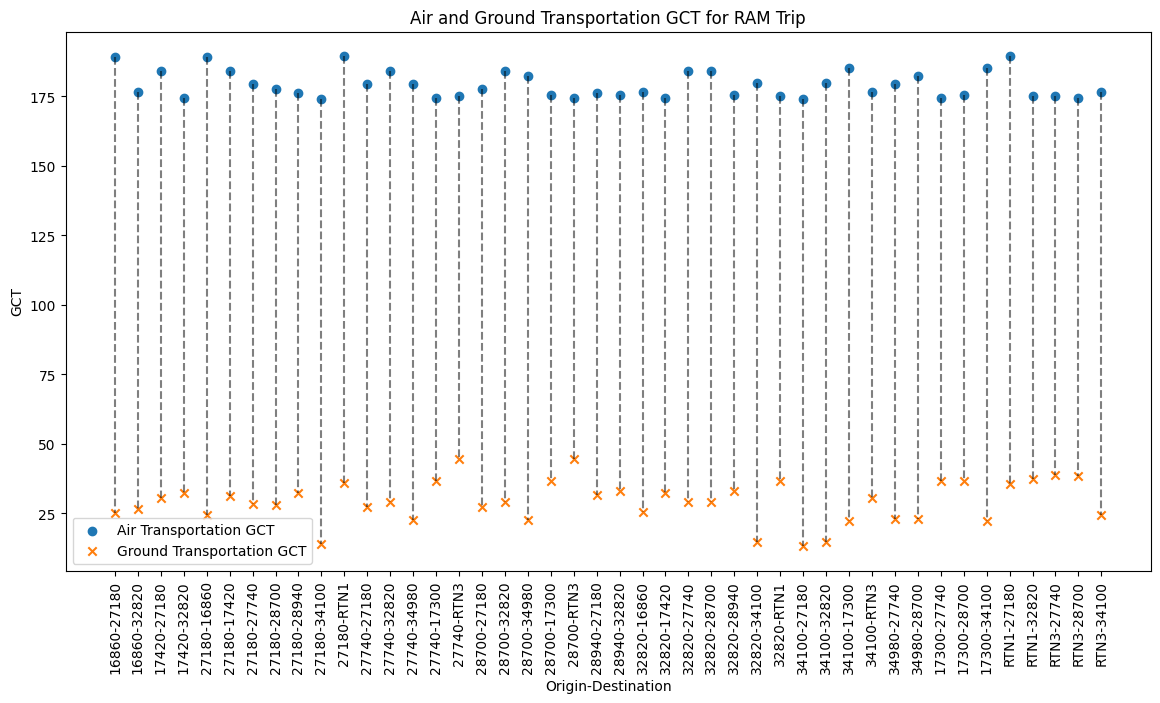

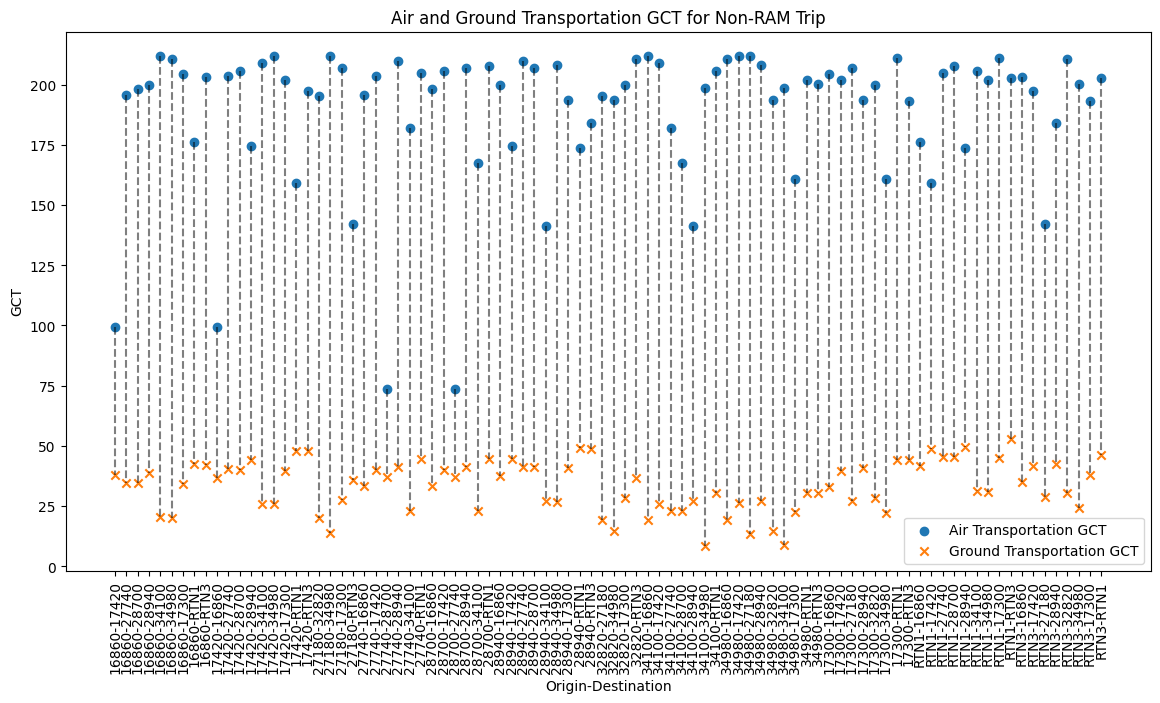

In [45]:
# Filter the data based on RAM_Trip
df_RAM_Trip_1 = df[df['RAM_Trip'] == 1].copy()

# Creating a combined Origin-Destination column for better labels
df_RAM_Trip_1['Origin-Destination'] = df_RAM_Trip_1['Origin'].astype(str) + '-' + df_RAM_Trip_1['Destination'].astype(str)

# Plotting the scatter plot for Distance_A and Distance_G in the same figure
plt.figure(figsize=(14, 7))

# Scatter plot for Distance_A
plt.scatter(df_RAM_Trip_1['Origin-Destination'], df_RAM_Trip_1['GCT_A'], label='Air Transportation GCT', marker='o')

# Scatter plot for Distance_G
plt.scatter(df_RAM_Trip_1['Origin-Destination'], df_RAM_Trip_1['GCT_Total_G'], label='Ground Transportation GCT', marker='x')

# Drawing dotted lines between Time_A and Time_G of the same OD pair
for i in range(len(df_RAM_Trip_1)):
    plt.plot([df_RAM_Trip_1['Origin-Destination'].iloc[i], df_RAM_Trip_1['Origin-Destination'].iloc[i]],
             [df_RAM_Trip_1['GCT_A'].iloc[i], df_RAM_Trip_1['GCT_Total_G'].iloc[i]], 'k--', alpha=0.5)

# Adding titles and labels
plt.title('Air and Ground Transportation GCT for RAM Trip')
plt.xlabel('Origin-Destination')
plt.ylabel('GCT')
plt.xticks(rotation=90)
plt.legend()

# Display the plot
plt.show()


# Filter the data based on RAM_Trip
df_RAM_Trip_0 = df[df['RAM_Trip'] == 0].copy()

# Creating a combined Origin-Destination column for better labels
df_RAM_Trip_0['Origin-Destination'] = df_RAM_Trip_0['Origin'].astype(str) + '-' + df_RAM_Trip_0['Destination'].astype(str)

# Plotting the scatter plot for Distance_A and Distance_G in the same figure
plt.figure(figsize=(14, 7))

# Scatter plot for Distance_A
plt.scatter(df_RAM_Trip_0['Origin-Destination'], df_RAM_Trip_0['GCT_A'], label='Air Transportation GCT', marker='o')

# Scatter plot for Distance_G
plt.scatter(df_RAM_Trip_0['Origin-Destination'], df_RAM_Trip_0['GCT_Total_G'], label='Ground Transportation GCT', marker='x')

# Drawing dotted lines between Time_A and Time_G of the same OD pair
for i in range(len(df_RAM_Trip_0)):
    plt.plot([df_RAM_Trip_0['Origin-Destination'].iloc[i], df_RAM_Trip_0['Origin-Destination'].iloc[i]],
             [df_RAM_Trip_0['GCT_A'].iloc[i], df_RAM_Trip_0['GCT_Total_G'].iloc[i]], 'k--', alpha=0.5)

# Adding titles and labels
plt.title('Air and Ground Transportation GCT for Non-RAM Trip')
plt.xlabel('Origin-Destination')
plt.ylabel('GCT')
plt.xticks(rotation=90)
plt.legend()

# Display the plot
plt.show()